# Markowitz++ with Options — Demo Notebook

This notebook provides:
1. **Data snapshot** — what we have, quality checks
2. **RND distributions** — visualize the risk-neutral density for each asset
3. **Parameter dashboard** — current hyperparameters, easy to tweak
4. **Backtest runner** — change params and re-run in one cell

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib
matplotlib.use("agg")

import sys, os, logging, importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display

PROJECT_ROOT = Path(os.getcwd())
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

logging.basicConfig(level=logging.WARNING, force=True)
logging.getLogger("data.forecasts").setLevel(logging.WARNING)

import config
import data.forecasts as _forecasts_mod
import backtest as bt
importlib.reload(config)
importlib.reload(_forecasts_mod)
importlib.reload(bt)

from config import (
    SPY_DAILY_FILE, OPTION_CHAINS_DIR, CASH_RATE_FILE,
    TARGET_MIN_DTE, TARGET_MAX_DTE, TARGET_IDEAL_DTE,
    REBALANCE_DAYS, OPTION_RETURN_WINSORIZE_PCT,
    MIN_BL_STRIKES, MIN_OPTION_MID, MAX_BID_ASK_SPREAD_PCT,
    PROCESSED_DIR,
)
from data.forecasts import (
    compute_rnd_forecasts, load_chain_for_expiry, ASSET_ORDER,
    _get_atm_iv, _bs_call_price, _bs_put_price,
    _lognormal_sample, breeden_litzenberger_pdf,
    _bs_call_vec, _bs_put_vec,
)

plt.rcParams.update({
    "figure.dpi": 120,
    "axes.grid": True,
    "grid.alpha": 0.3,
    "font.size": 10,
})
print("Imports OK")

Imports OK


---
## 1  Data Snapshot

In [3]:
# SPY equity bars
spy = pd.read_parquet(SPY_DAILY_FILE)
spy.index = pd.to_datetime(spy.index).tz_localize(None).normalize()
print(f"SPY bars: {len(spy):,}  ({spy.index[0].date()} to {spy.index[-1].date()})")
print(f"Latest close: ${spy['close'].iloc[-1]:.2f}")

# Option chain dates
chain_dates = sorted(set(
    f.stem.replace("calls_", "")
    for f in OPTION_CHAINS_DIR.glob("calls_*.parquet")
    if (OPTION_CHAINS_DIR / f"puts_{f.stem.replace('calls_','')}.parquet").exists()
))
print(f"Option chain snapshots: {len(chain_dates)}")
print(f"  First: {chain_dates[0]}   Last: {chain_dates[-1]}")

# Quick chain quality for the latest date
d = chain_dates[-1]
calls_raw = pd.read_parquet(OPTION_CHAINS_DIR / f"calls_{d}.parquet")
puts_raw  = pd.read_parquet(OPTION_CHAINS_DIR / f"puts_{d}.parquet")
print(f"\nLatest chain ({d}):")
print(f"  Calls: {len(calls_raw)}   Puts: {len(puts_raw)}")
for label, df in [("Calls", calls_raw), ("Puts", puts_raw)]:
    cols_lower = [c.lower() for c in df.columns]
    has_bid = any('bid' in c for c in cols_lower)
    has_iv  = any('implied' in c or 'impl_vol' in c for c in cols_lower)
    print(f"  {label} — columns: {list(df.columns[:8])}{'...' if len(df.columns)>8 else ''}")
    if has_bid:
        bid_col = [c for c in df.columns if 'bid' in c.lower()][0]
        print(f"    bid > 0: {(df[bid_col] > 0).sum()}/{len(df)} ({(df[bid_col] > 0).mean():.0%})")

SPY bars: 1,540  (2020-01-02 to 2026-02-18)
Latest close: $686.29
Option chain snapshots: 50
  First: 2024-02-01   Last: 2026-02-18

Latest chain (2026-02-18):
  Calls: 621   Puts: 621
  Calls — columns: ['contractSymbol', 'expiry', 'strike', 'lastPrice', 'bid', 'ask', 'impliedVolatility', 'delta']...
    bid > 0: 621/621 (100%)
  Puts — columns: ['contractSymbol', 'expiry', 'strike', 'lastPrice', 'bid', 'ask', 'impliedVolatility', 'delta']...
    bid > 0: 621/621 (100%)


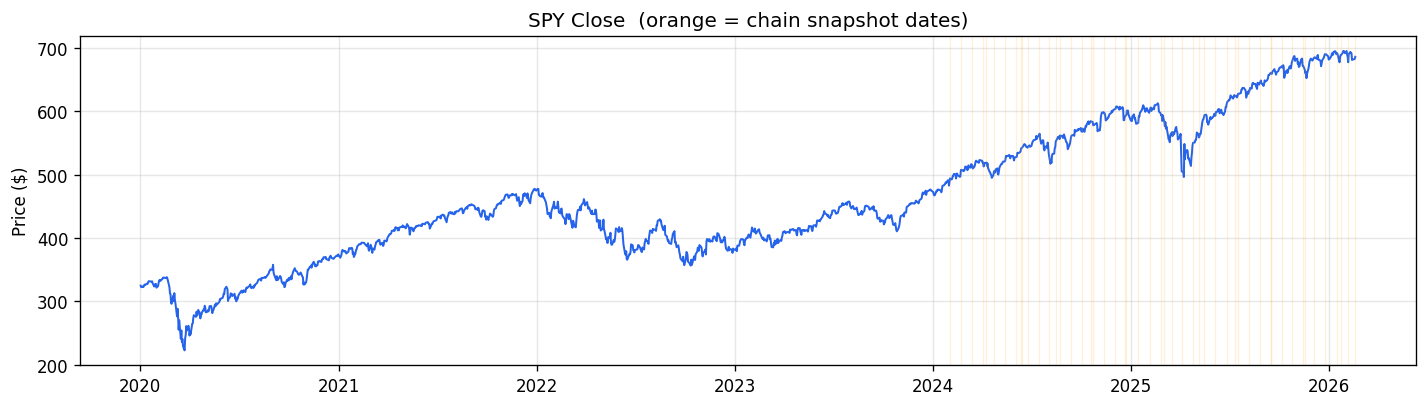

In [4]:
# SPY price history
fig, ax = plt.subplots(figsize=(12, 3.5))
ax.plot(spy.index, spy["close"], color="#2563eb", linewidth=1.2)
for d in chain_dates:
    ax.axvline(pd.Timestamp(d), color="orange", alpha=0.15, linewidth=0.8)
ax.set_title("SPY Close  (orange = chain snapshot dates)")
ax.set_ylabel("Price ($)")
plt.tight_layout()
display(fig)
plt.close(fig)

---
## 2  RND Distributions

We compute the Risk-Neutral Distribution for a **single recent chain date** and visualize:
- The sampled terminal spot distribution (BL or lognormal fallback)
- Implied return distributions for SPY, Call, Put, and Cash

In [5]:
# Pick a chain date to inspect (latest by default)
DEMO_DATE = chain_dates[-1]

ts = pd.Timestamp(DEMO_DATE)
idx = spy.index.get_indexer([ts], method="ffill")[0]
spot = float(spy.iloc[idx]["close"])

mu, Sigma, diag = compute_rnd_forecasts(
    chain_date=DEMO_DATE, spot=spot, n_samples=20_000, return_diagnostics=True,
)

print(f"Chain date: {DEMO_DATE}   Spot: ${spot:.2f}")
print(f"Method: {diag['method']}")
print(f"Expiry: {diag['expiry']}  DTE: {diag['dte']}")
print(f"ATM IV: {diag['atm_iv']:.2%}")
print(f"K_ATM: {diag['k_atm']:.0f}   C_ATM: ${diag['c_atm']:.4f}   P_ATM: ${diag['p_atm']:.4f}")
print(f"Calls after filter: {diag['n_calls_after_filter']}   Puts: {diag['n_puts_after_filter']}")
print(f"BL interior strikes: {diag['n_interior_strikes']}")
print(f"Mode: {'hold-to-expiry' if not diag['horizon_reprice'] else 'horizon-reprice'}")

Chain date: 2026-02-18   Spot: $686.29
Method: breeden_litzenberger
Expiry: 2026-03-31  DTE: 41
ATM IV: 14.72%
K_ATM: 686   C_ATM: $15.3700   P_ATM: $14.2550
Calls after filter: 145   Puts: 147
BL interior strikes: 498
Mode: horizon-reprice


In [6]:
print("\n===  mu (expected return per period)  ===")
for asset in ASSET_ORDER:
    print(f"  {asset:12s} {mu[asset]:+.4%}")

print("\n===  Sigma (covariance matrix)  ===")
print(Sigma.to_string(float_format="{:.6f}".format))

stds = np.sqrt(np.diag(Sigma.values))
corr = Sigma.values / np.outer(stds + 1e-12, stds + 1e-12)
print("\n===  Correlations  ===")
print(pd.DataFrame(corr, index=ASSET_ORDER, columns=ASSET_ORDER).to_string(float_format="{:.3f}".format))


===  mu (expected return per period)  ===
  SPY          +0.7540%
  SPY_CALL     +13.0787%
  SPY_PUT      -34.2189%
  USDOLLAR     +0.1920%

===  Sigma (covariance matrix)  ===
               SPY  SPY_CALL   SPY_PUT  USDOLLAR
SPY       0.000647  0.000323 -0.000323  0.000000
SPY_CALL  0.000323  0.000226 -0.000162  0.000000
SPY_PUT  -0.000323 -0.000162  0.000226  0.000000
USDOLLAR  0.000000  0.000000  0.000000  0.000000

===  Correlations  ===
            SPY  SPY_CALL  SPY_PUT  USDOLLAR
SPY       1.000     0.845   -0.845     0.000
SPY_CALL  0.845     1.000   -0.714     0.000
SPY_PUT  -0.845    -0.714    1.000     0.000
USDOLLAR  0.000     0.000    0.000     1.000


Pricing mode: Horizon reprice (T_remain=0.074yr)


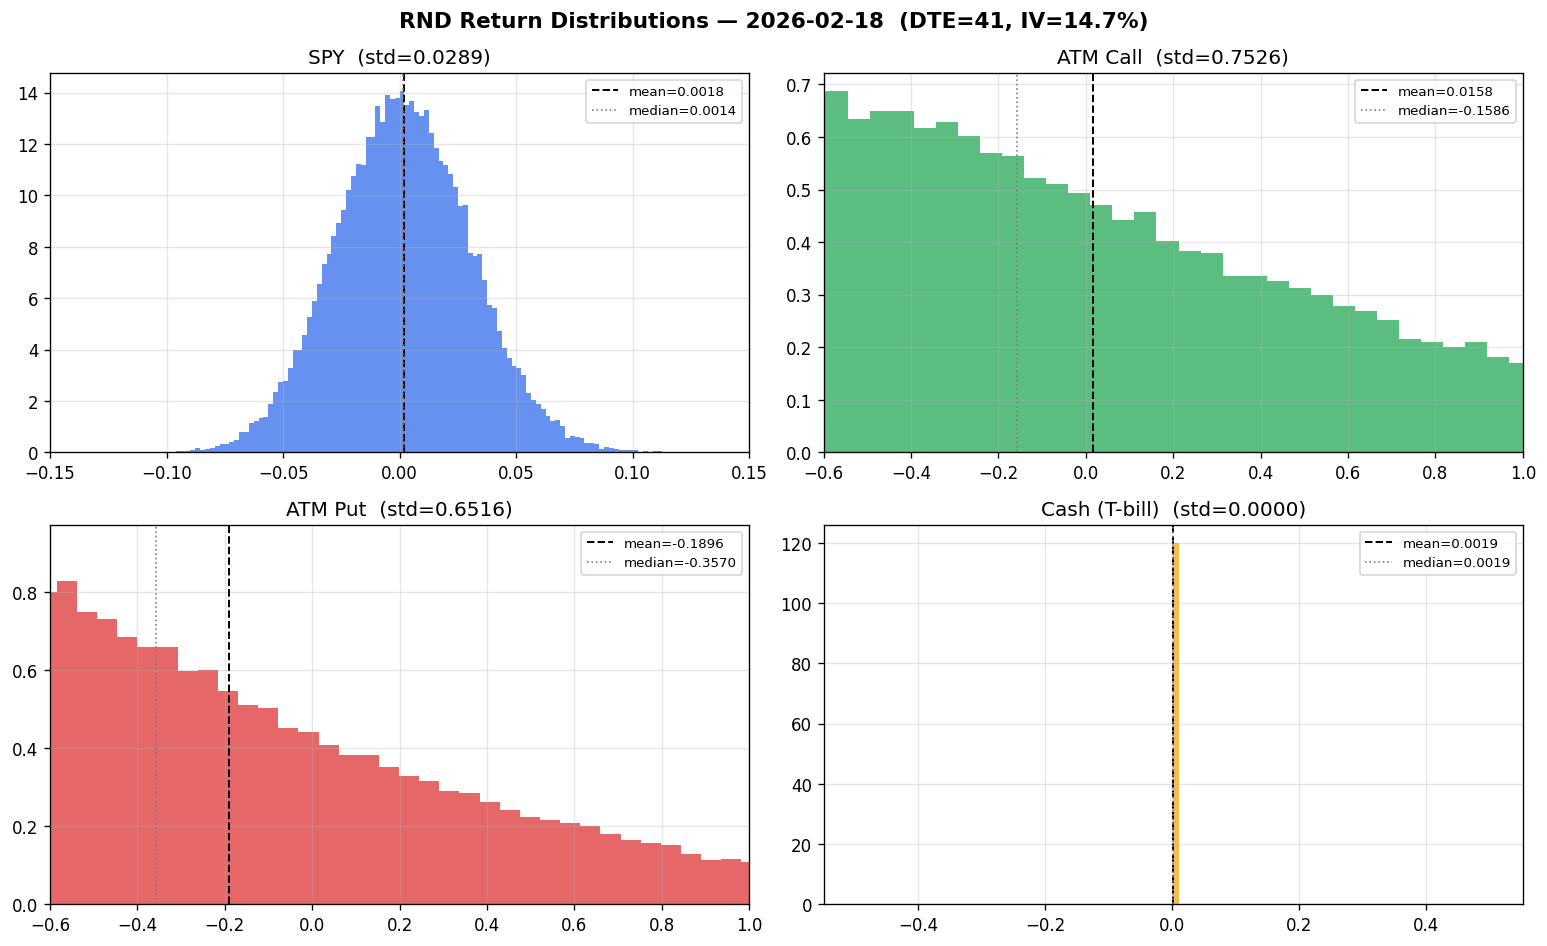

In [7]:
# Re-sample for plotting (separate call to get the raw S_next)
np.random.seed(42)
T = diag["T_expiry_years"]
T_rebal = diag["T_rebal_years"]
T_remain = diag["T_remain_years"]
atm_iv = diag["atm_iv"]
r = 0.05
k_atm = diag["k_atm"]
c_atm = diag["c_atm"]
p_atm = diag["p_atm"]

T_sample = T_rebal if REBALANCE_DAYS else T
S_next = _lognormal_sample(spot, r, T_sample, atm_iv, 50_000)
r_spy  = S_next / spot - 1.0

# Horizon repricing: BS-reprice options at rebalance with remaining time
if T_remain > 1e-6:
    C_t1 = _bs_call_vec(S_next, k_atm, r, T_remain, atm_iv)
    P_t1 = _bs_put_vec(S_next, k_atm, r, T_remain, atm_iv)
    mode_label = f"Horizon reprice (T_remain={T_remain:.3f}yr)"
else:
    C_t1 = np.maximum(S_next - k_atm, 0.0)
    P_t1 = np.maximum(k_atm - S_next, 0.0)
    mode_label = "Terminal payoff (T_remain≈0)"
r_call = C_t1 / c_atm - 1.0
r_put  = P_t1 / p_atm - 1.0
r_cash = np.full_like(S_next, np.exp(r * T_sample) - 1.0)
print(f"Pricing mode: {mode_label}")

fig, axes = plt.subplots(2, 2, figsize=(13, 8))
fig.suptitle(
    f"RND Return Distributions — {DEMO_DATE}  (DTE={diag['dte']}, IV={atm_iv:.1%})",
    fontsize=13, fontweight="bold",
)

configs = [
    (axes[0, 0], r_spy,  "SPY",        "#2563eb", (-0.15, 0.15)),
    (axes[0, 1], r_call, "ATM Call",    "#16a34a", (-0.6, 1.0)),
    (axes[1, 0], r_put,  "ATM Put",     "#dc2626", (-0.6, 1.0)),
    (axes[1, 1], r_cash, "Cash (T-bill)", "#f59e0b", None),
]

for ax, data, label, color, xlim in configs:
    clipped = np.clip(data, -1.5, 10.0)
    ax.hist(clipped, bins=120, density=True, color=color, alpha=0.7, edgecolor="none")
    ax.axvline(np.mean(data), color="k", linestyle="--", linewidth=1.2,
               label=f"mean={np.mean(data):.4f}")
    ax.axvline(np.median(data), color="gray", linestyle=":", linewidth=1.0,
               label=f"median={np.median(data):.4f}")
    ax.set_title(f"{label}  (std={np.std(data):.4f})")
    ax.legend(fontsize=8)
    if xlim:
        ax.set_xlim(xlim)

plt.tight_layout()
display(fig)
plt.close(fig)

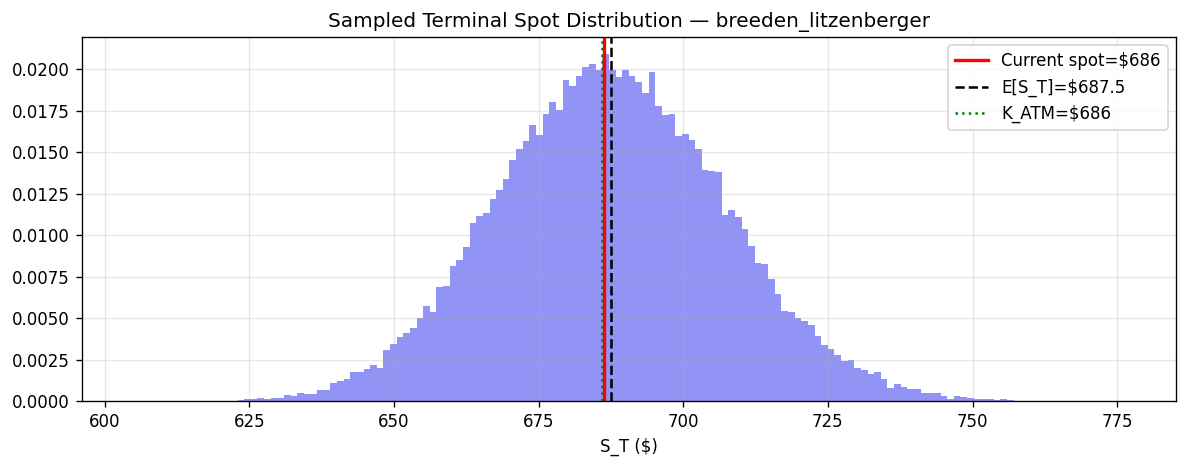

In [8]:
# Spot distribution
fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(S_next, bins=150, density=True, color="#6366f1", alpha=0.7, edgecolor="none")
ax.axvline(spot, color="red", linewidth=2, label=f"Current spot=${spot:.0f}")
ax.axvline(np.mean(S_next), color="k", linewidth=1.5, linestyle="--",
           label=f"E[S_T]=${np.mean(S_next):.1f}")
ax.axvline(k_atm, color="green", linewidth=1.5, linestyle=":",
           label=f"K_ATM=${k_atm:.0f}")
ax.set_title(f"Sampled Terminal Spot Distribution — {diag['method']}")
ax.set_xlabel("S_T ($)")
ax.legend()
plt.tight_layout()
display(fig)
plt.close(fig)

---
## 3  Parameter Dashboard

All tunable parameters in one place.  
**Change values below, then re-run section 4 to see the effect.**

In [8]:
# ====================================================================
#  TUNABLE PARAMETERS — edit these and re-run Section 4
# ====================================================================

# Risk aversion: higher = less risky portfolio (penalizes variance in objective)
# Try: 2 (aggressive), 5 (moderate), 10 (conservative), 20 (very conservative)
GAMMA = 10.0

# Hard portfolio volatility cap per period (SOCP constraint)
# sqrt(w'Σw) <= this value.  Note: option std ≈ 20x SPY std.
# Try: 0.02 (tight), 0.04 (moderate), 0.08 (loose), None (disabled)
MAX_PORT_VOL = 0.04

# Maximum weight in each option sleeve (3% ≈ 60% notional via 20x leverage)
# Try: 0.01 (tiny), 0.03 (small), 0.05 (moderate), 0.10 (aggressive)
MAX_OPTION_WEIGHT = 0.03

# Maximum weight in SPY equity sleeve
# Try: 0.60 (leave room for options+cash), 0.80, 1.00 (uncapped)
MAX_SPY_WEIGHT = 1.0

# Minimum cash allocation (floor)
MIN_CASH_WEIGHT = 0.10

# Maximum turnover per rebalance (L1 norm)
MAX_TURNOVER = 0.40

# Transaction cost rate (fraction of turnover)
TCOST_RATE = 0.001

# Rolling window for historical mu (number of periods)
ROLLING_WINDOW = 13

# Shrinkage of rolling mu toward cash rate (0 = pure historical, 1 = all cash rate)
MU_SHRINKAGE = 0.5

# ====================================================================
#  ROBUST OPTIMIZATION  (from MVO_70 and cov_pred_finance papers)
# ====================================================================

# Per-asset return uncertainty penalty (ρ): hedges μ estimation error.
# For long-only portfolios: effective return = μ − ρ.
# Try: 0.001 (mild), 0.005 (moderate), 0.01 (aggressive)
ROBUST_MU_UNCERTAINTY = 0.005

# Covariance diagonal boost factor (κ): hedges Σ estimation error.
# Worst-case covariance: Σ_wc = Σ + κ·diag(Σ).
# Try: 0.05 (mild), 0.10 (moderate), 0.25 (aggressive)
ROBUST_COV_UNCERTAINTY = 0.10

# IEWMA blend weight: fraction of Σ from historical IEWMA vs option-implied RND.
# 0.0 = pure RND, 1.0 = pure IEWMA, 0.5 = equal blend.
# Try: 0.0, 0.25, 0.50, 0.75, 1.0
IEWMA_WEIGHT = 0.50

print("Parameters set:")
print(f"  GAMMA              = {GAMMA}")
print(f"  MAX_PORT_VOL       = {MAX_PORT_VOL:.2%} per period")
print(f"  MAX_OPTION_WT      = {MAX_OPTION_WEIGHT:.0%}")
print(f"  MAX_SPY_WT         = {MAX_SPY_WEIGHT:.0%}")
print(f"  MIN_CASH_WT        = {MIN_CASH_WEIGHT:.0%}")
print(f"  MAX_TURNOVER       = {MAX_TURNOVER}")
print(f"  TCOST_RATE         = {TCOST_RATE}")
print(f"  ROLLING_WINDOW     = {ROLLING_WINDOW}")
print(f"  MU_SHRINKAGE       = {MU_SHRINKAGE}")
print(f"  ROBUST_MU_UNCERT   = {ROBUST_MU_UNCERTAINTY}")
print(f"  ROBUST_COV_UNCERT  = {ROBUST_COV_UNCERTAINTY}")
print(f"  IEWMA_WEIGHT       = {IEWMA_WEIGHT}")

Parameters set:
  GAMMA              = 10.0
  MAX_PORT_VOL       = 4.00% per period
  MAX_OPTION_WT      = 3%
  MAX_SPY_WT         = 100%
  MIN_CASH_WT        = 10%
  MAX_TURNOVER       = 0.4
  TCOST_RATE         = 0.001
  ROLLING_WINDOW     = 13
  MU_SHRINKAGE       = 0.5
  ROBUST_MU_UNCERT   = 0.005
  ROBUST_COV_UNCERT  = 0.1
  IEWMA_WEIGHT       = 0.5


---
## 4  Run Backtest

This cell patches the `backtest` module with the parameters above and re-runs the experiment.

In [9]:
# Patch backtest module with notebook parameters
bt.GAMMA = GAMMA
bt.MAX_PORT_VOL = MAX_PORT_VOL
bt.MAX_OPTION_WEIGHT = MAX_OPTION_WEIGHT
bt.MAX_SPY_WEIGHT = MAX_SPY_WEIGHT
bt.MIN_CASH_WEIGHT = MIN_CASH_WEIGHT
bt.MAX_TURNOVER = MAX_TURNOVER
bt.TCOST_RATE = TCOST_RATE
bt.ROLLING_WINDOW = ROLLING_WINDOW
bt.MU_SHRINKAGE = MU_SHRINKAGE
bt.ROBUST_MU_UNCERTAINTY = ROBUST_MU_UNCERTAINTY
bt.ROBUST_COV_UNCERTAINTY = ROBUST_COV_UNCERTAINTY
bt.IEWMA_WEIGHT = IEWMA_WEIGHT

print("Running backtest with updated parameters ...")
portfolio_df, weights_df, returns, mu_df, diag_summary = bt.run_backtest()

pv = portfolio_df["value"].values
spy_cum = (1 + returns["SPY"]).cumprod()
period_rets = np.diff(pv) / pv[:-1]
ann_factor = np.sqrt(252 / max(bt.REBAL_DAYS, 1))

print("\n========== Results ==========")
print(f"Periods:  {diag_summary['n_periods']}")
print(f"Range:    {returns.index[0].date()} to {returns.index[-1].date()}")
print(f"Return:   {pv[-1] / pv[0] - 1:+.2%}  (SPY B&H: {spy_cum.iloc[-1] - 1:+.2%})")
print(f"Sharpe:   {np.mean(period_rets) / (np.std(period_rets) + 1e-12) * ann_factor:.2f}")
print(f"Vol (ann): {np.std(period_rets) * ann_factor:.2%}")
print(f"Max DD:   {np.min(pv / np.maximum.accumulate(pv)) - 1:.1%}")
print(f"BL used:  {diag_summary['n_bl']}/{diag_summary['n_rnd_computed']}")

Running backtest with updated parameters ...

========== Results ==========
Periods:  49
Range:    2024-02-22 to 2026-02-18
Return:   +4.42%  (SPY B&H: +40.29%)
Sharpe:   0.25
Vol (ann): 2.07%
Max DD:   -4.6%
BL used:  50/50


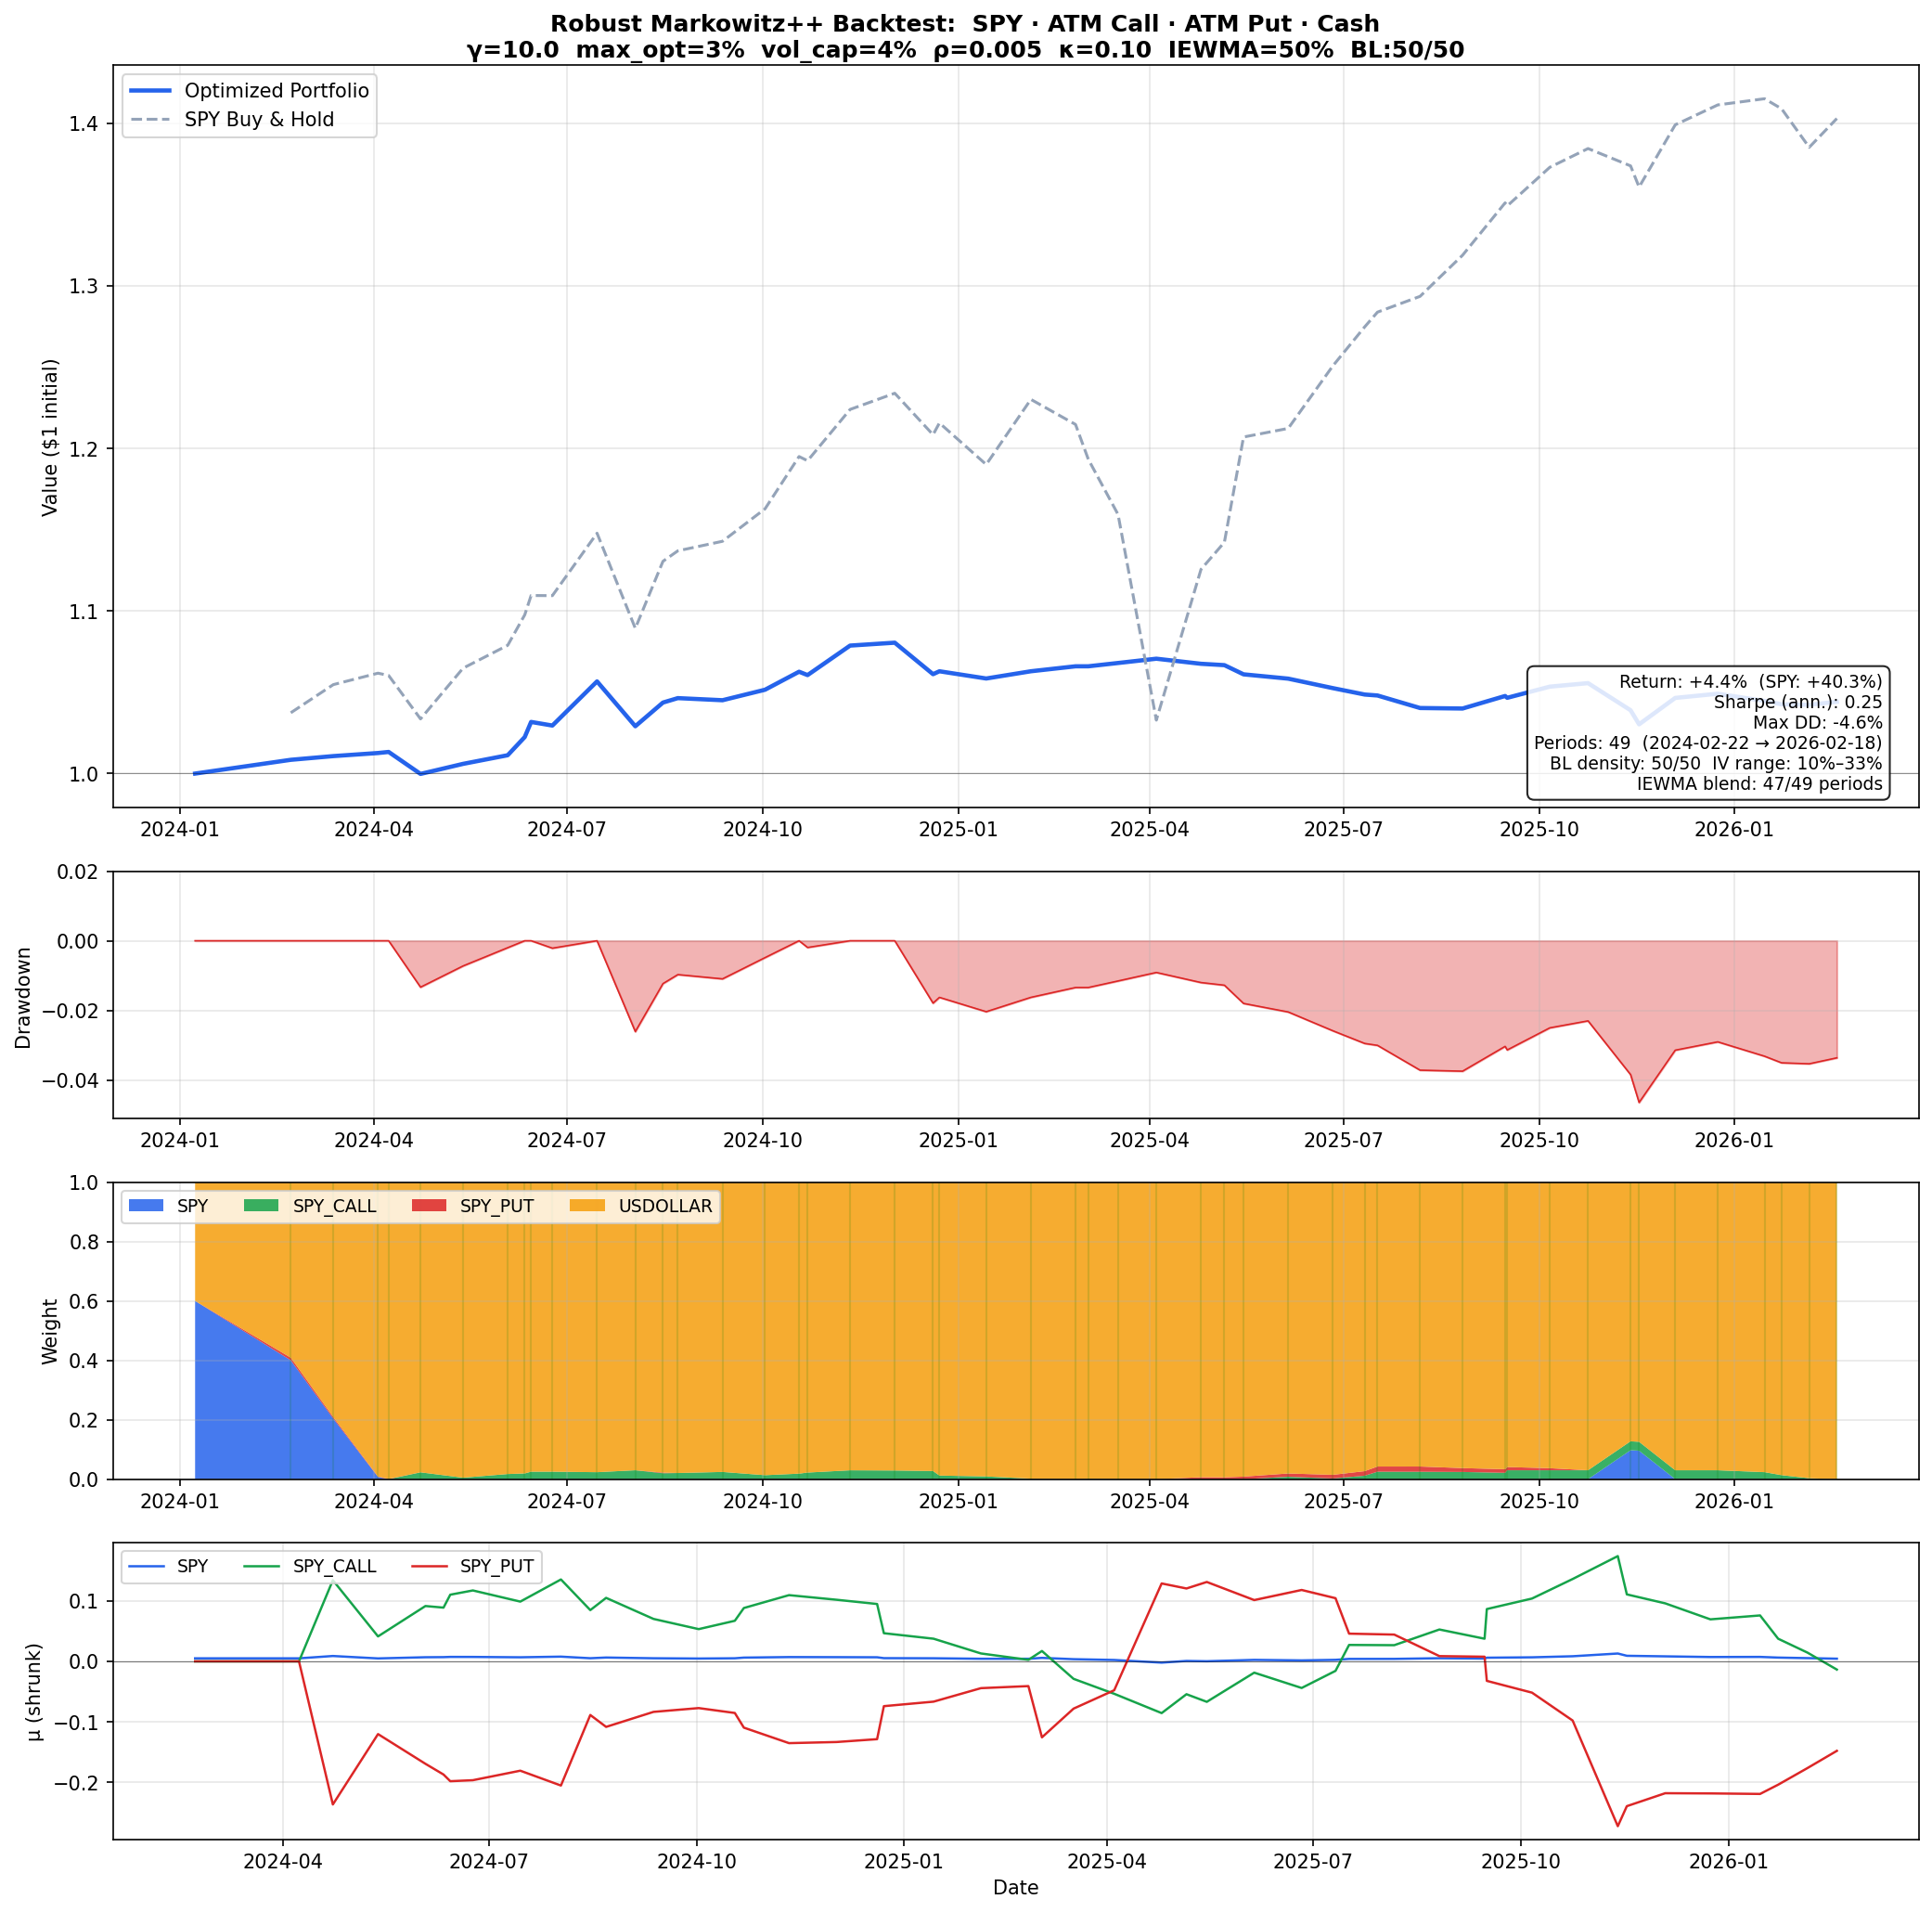

In [10]:
# Plot results
save_path = str(PROCESSED_DIR / "backtest_results.png")
bt.plot_results(portfolio_df, weights_df, returns, mu_df, diag_summary, save_path=save_path)

from IPython.display import Image, display
display(Image(filename=save_path, width=900))

In [11]:
# Allocation breakdown at final period
print("Final weights:")
for asset in ASSET_ORDER:
    print(f"  {asset:12s} {weights_df[asset].iloc[-1]:6.1%}")

# Period-level portfolio vol vs SPY vol
port_vol = np.std(period_rets)
spy_vol  = returns["SPY"].std()
print(f"\nPer-period vol: Portfolio={port_vol:.4f}  SPY={spy_vol:.4f}  Ratio={port_vol/spy_vol:.2f}x")
print(f"Annualized vol: Portfolio={port_vol*ann_factor:.2%}  SPY={spy_vol*ann_factor:.2%}")

Final weights:
  SPY            0.0%
  SPY_CALL       0.0%
  SPY_PUT        0.0%
  USDOLLAR     100.0%

Per-period vol: Portfolio=0.0087  SPY=0.0287  Ratio=0.31x
Annualized vol: Portfolio=2.07%  SPY=6.78%


---
## 5  Full Combinatorial Parameter Sweep (Robust Optimization)

Sweep **all combinations** of the following parameters, testing each with both the
**RND** (IV-space Breeden-Litzenberger, lognormal fallback) and the
**lognormal IV-only** distribution.  This sweep now includes **robust optimization**
parameters from the MVO_70 and cov_pred_finance papers:

| Parameter | Values |
|---|---|
| `GAMMA` (risk aversion) | 2, 10, 50 |
| `MAX_OPTION_WEIGHT` | 0%, 3%, 10% |
| `MAX_SPY_WEIGHT` | 60%, 80%, 100% |
| `REBALANCE_DAYS` | 7, 14, 21 |
| `MU_UNCERTAINTY` (ρ) | 0, 0.005, 0.01 |
| `COV_UNCERTAINTY` (κ) | 0, 0.10, 0.25 |
| `IEWMA_WEIGHT` | 0, 0.50, 1.0 |
| Distribution | RND, Lognormal |

> **Note:** This is a large sweep. Expect it to take a while.

In [12]:
import importlib, itertools, time as _time
import config as _cfg
from data.covariance import CMIEWMAPredictor

SWEEP_GAMMAS        = [2, 10, 50]
SWEEP_MAX_OPT_WT    = [0.00, 0.03, 0.10]
SWEEP_MAX_SPY_WT    = [0.60, 0.80, 1.00]
SWEEP_REBAL_DAYS    = [7, 14, 21]
SWEEP_DISTRIBUTIONS = ["rnd", "lognormal"]
SWEEP_MU_UNCERT     = [0.0, 0.005, 0.01]
SWEEP_COV_UNCERT    = [0.0, 0.10, 0.25]
SWEEP_IEWMA_WT      = [0.0, 0.50, 1.0]

original_rebal    = _cfg.REBALANCE_DAYS
original_force_ln = _forecasts_mod.FORCE_LOGNORMAL

all_results = []
combos_inner = list(itertools.product(
    SWEEP_GAMMAS, SWEEP_MAX_OPT_WT, SWEEP_MAX_SPY_WT,
    SWEEP_MU_UNCERT, SWEEP_COV_UNCERT, SWEEP_IEWMA_WT,
))
n_outer = len(SWEEP_REBAL_DAYS) * len(SWEEP_DISTRIBUTIONS)
n_inner = len(combos_inner)
total_runs = n_outer * n_inner
run_count = 0
t0 = _time.time()

print(f"Total runs: {total_runs}  ({n_outer} outer × {n_inner} inner)")

for rd in SWEEP_REBAL_DAYS:
    for dist in SWEEP_DISTRIBUTIONS:
        _cfg.REBALANCE_DAYS = rd
        _forecasts_mod.FORCE_LOGNORMAL = (dist == "lognormal")
        importlib.reload(_forecasts_mod)
        importlib.reload(bt)

        for g, mow, msw, mu_u, cov_u, iew_w in combos_inner:
            bt.GAMMA = g
            bt.MAX_PORT_VOL = MAX_PORT_VOL
            bt.MAX_OPTION_WEIGHT = mow
            bt.MAX_SPY_WEIGHT = msw
            bt.MIN_CASH_WEIGHT = MIN_CASH_WEIGHT
            bt.MAX_TURNOVER = MAX_TURNOVER
            bt.MU_SHRINKAGE = MU_SHRINKAGE
            bt.ROLLING_WINDOW = ROLLING_WINDOW
            bt.ROBUST_MU_UNCERTAINTY = mu_u
            bt.ROBUST_COV_UNCERTAINTY = cov_u
            bt.IEWMA_WEIGHT = iew_w

            pf, wf, ret, mf, ds = bt.run_backtest()
            pv_ = pf["value"].values
            pr_ = np.diff(pv_) / pv_[:-1]
            _af = np.sqrt(252 / max(rd, 1))
            sharpe_ = np.mean(pr_) / (np.std(pr_) + 1e-12) * _af
            vol_    = np.std(pr_) * _af
            total_  = pv_[-1] / pv_[0] - 1

            all_results.append({
                "gamma": g,
                "max_opt_wt": mow,
                "max_spy_wt": msw,
                "rebal_days": rd,
                "distribution": dist,
                "mu_uncertainty": mu_u,
                "cov_uncertainty": cov_u,
                "iewma_weight": iew_w,
                "return": total_,
                "sharpe": sharpe_,
                "ann_vol": vol_,
            })
            run_count += 1
            if run_count % max(total_runs // 10, 1) == 0 or run_count == total_runs:
                elapsed = _time.time() - t0
                print(f"  [{run_count}/{total_runs}]  elapsed {elapsed:.0f}s")

# Restore original config
_cfg.REBALANCE_DAYS = original_rebal
_forecasts_mod.FORCE_LOGNORMAL = original_force_ln
importlib.reload(_forecasts_mod)
importlib.reload(bt)
bt.GAMMA = GAMMA
bt.MAX_PORT_VOL = MAX_PORT_VOL
bt.MAX_OPTION_WEIGHT = MAX_OPTION_WEIGHT
bt.MAX_SPY_WEIGHT = MAX_SPY_WEIGHT
bt.MIN_CASH_WEIGHT = MIN_CASH_WEIGHT
bt.MAX_TURNOVER = MAX_TURNOVER
bt.MU_SHRINKAGE = MU_SHRINKAGE
bt.ROLLING_WINDOW = ROLLING_WINDOW
bt.ROBUST_MU_UNCERTAINTY = ROBUST_MU_UNCERTAINTY
bt.ROBUST_COV_UNCERTAINTY = ROBUST_COV_UNCERTAINTY
bt.IEWMA_WEIGHT = IEWMA_WEIGHT

sweep_df = pd.DataFrame(all_results)
print(f"\nSweep complete: {len(sweep_df)} runs in {_time.time() - t0:.0f}s")
display(sweep_df.head(10))

Total runs: 4374  (6 outer × 729 inner)
  [437/4374]  elapsed 2835s
  [874/4374]  elapsed 5603s
  [1311/4374]  elapsed 8322s
  [1748/4374]  elapsed 11059s
  [2185/4374]  elapsed 13794s
  [2622/4374]  elapsed 16520s
  [3059/4374]  elapsed 19241s
  [3496/4374]  elapsed 21961s
  [3933/4374]  elapsed 24718s
  [4370/4374]  elapsed 27590s
  [4374/4374]  elapsed 27617s

Sweep complete: 4374 runs in 27617s


,gamma,max_opt_wt,max_spy_wt,rebal_days,distribution,mu_uncertainty,cov_uncertainty,iewma_weight,return,sharpe,ann_vol
0,2,0.0,0.6,7,rnd,0.000,0.00,0.0,0.125236,5.939960,0.014630
1,2,0.0,0.6,7,rnd,0.000,0.00,0.5,0.125246,5.940612,0.014629
2,2,0.0,0.6,7,rnd,0.000,0.00,1.0,0.125308,5.945118,0.014625
3,2,0.0,0.6,7,rnd,0.000,0.10,0.0,0.125232,5.939646,0.014630
4,2,0.0,0.6,7,rnd,0.000,0.10,0.5,0.125245,5.940670,0.014629
5,2,0.0,0.6,7,rnd,0.000,0.10,1.0,0.125306,5.945130,0.014625
6,2,0.0,0.6,7,rnd,0.000,0.25,0.0,0.125236,5.939943,0.014630
7,2,0.0,0.6,7,rnd,0.000,0.25,0.5,0.125244,5.940611,0.014629
8,2,0.0,0.6,7,rnd,0.000,0.25,1.0,0.125306,5.945138,0.014625
9,2,0.0,0.6,7,rnd,0.005,0.00,0.0,0.125232,5.939703,0.014630


### 5a  RND vs Lognormal — Aggregate Comparison

Compare **overall** Sharpe and volatility between the two distribution methods,
averaged across all parameter combinations.

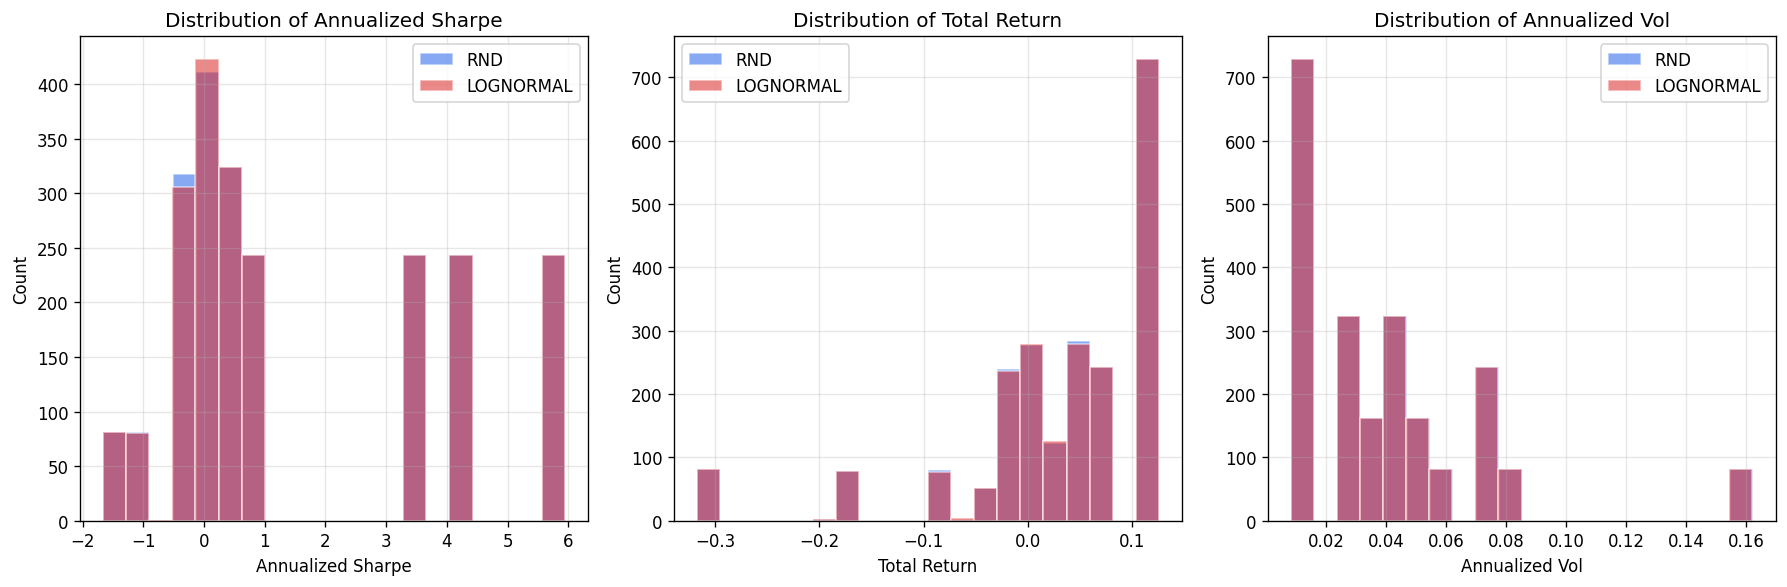


=== Aggregate stats by distribution ===


return                        sharpe                      \
                  mean    median       std      mean    median       std   
distribution                                                               
lognormal     0.033503  0.047189  0.099757  1.543345  0.469616  2.250277   
rnd           0.033457  0.047202  0.099847  1.543131  0.469725  2.250480   

               ann_vol                      
                  mean    median       std  
distribution                                
lognormal     0.039876  0.036903  0.032455  
rnd           0.039880  0.036902  0.032468


=== Aggregate stats by IEWMA weight ===


return                        sharpe                      \
                  mean    median       std      mean    median       std   
iewma_weight                                                               
0.0          -0.029048 -0.021738  0.139901  1.114588 -0.178308  2.530770   
0.5           0.063326  0.047200  0.047057  1.744359  0.469670  2.069729   
1.0           0.066161  0.062767  0.047213  1.770768  0.624769  2.057028   

               ann_vol                      
                  mean    median       std  
iewma_weight                                
0.0           0.050784  0.040142  0.045244  
0.5           0.033685  0.025693  0.022915  
1.0           0.035164  0.036903  0.020253


=== Aggregate stats by mu_uncertainty ===


return                        sharpe                      \
                    mean    median       std      mean    median       std   
mu_uncertainty                                                               
0.000           0.033453  0.047175  0.099899  1.543115  0.469506  2.250805   
0.005           0.033478  0.047254  0.099799  1.543209  0.470268  2.250678   
0.010           0.033508  0.047171  0.099742  1.543391  0.468360  2.250427   

                 ann_vol                      
                    mean    median       std  
mu_uncertainty                                
0.000           0.039885  0.036902  0.032481  
0.005           0.039874  0.036902  0.032450  
0.010           0.039875  0.036902  0.032466


=== Aggregate stats by cov_uncertainty ===


return                        sharpe                      \
                     mean    median       std      mean    median       std   
cov_uncertainty                                                               
0.00             0.033486  0.047270  0.099830  1.543301  0.469402  2.250603   
0.10             0.033428  0.047194  0.099912  1.543024  0.469916  2.250859   
0.25             0.033524  0.047160  0.099698  1.543390  0.469449  2.250447   

                  ann_vol                      
                     mean    median       std  
cov_uncertainty                                
0.00             0.039876  0.036903  0.032465  
0.10             0.039888  0.036902  0.032482  
0.25             0.039870  0.036902  0.032449

In [13]:
agg = sweep_df.groupby("distribution")[["return", "sharpe", "ann_vol"]].agg(["mean", "median", "std"])

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
metrics = [("sharpe", "Annualized Sharpe"), ("return", "Total Return"), ("ann_vol", "Annualized Vol")]
colors_dist = {"rnd": "#2563eb", "lognormal": "#dc2626"}

for ax, (col, label) in zip(axes, metrics):
    for dist in SWEEP_DISTRIBUTIONS:
        subset = sweep_df[sweep_df["distribution"] == dist][col]
        ax.hist(subset, bins=20, alpha=0.55, label=dist.upper(), color=colors_dist[dist], edgecolor="white")
    ax.set_xlabel(label)
    ax.set_ylabel("Count")
    ax.set_title(f"Distribution of {label}")
    ax.legend()

plt.tight_layout()
display(fig)
plt.close(fig)

print("\n=== Aggregate stats by distribution ===")
display(agg)

# Aggregate by IEWMA weight to see blending effect
print("\n=== Aggregate stats by IEWMA weight ===")
agg_iewma = sweep_df.groupby("iewma_weight")[["return", "sharpe", "ann_vol"]].agg(["mean", "median", "std"])
display(agg_iewma)

# Aggregate by robustness settings
print("\n=== Aggregate stats by mu_uncertainty ===")
agg_mu = sweep_df.groupby("mu_uncertainty")[["return", "sharpe", "ann_vol"]].agg(["mean", "median", "std"])
display(agg_mu)

print("\n=== Aggregate stats by cov_uncertainty ===")
agg_cov = sweep_df.groupby("cov_uncertainty")[["return", "sharpe", "ann_vol"]].agg(["mean", "median", "std"])
display(agg_cov)

### 5b  Per-Parameter Sensitivity (marginal effects)

For each parameter, plot the **average Sharpe** and **average Vol** across all other
parameter combinations. Separate lines for RND vs Lognormal.

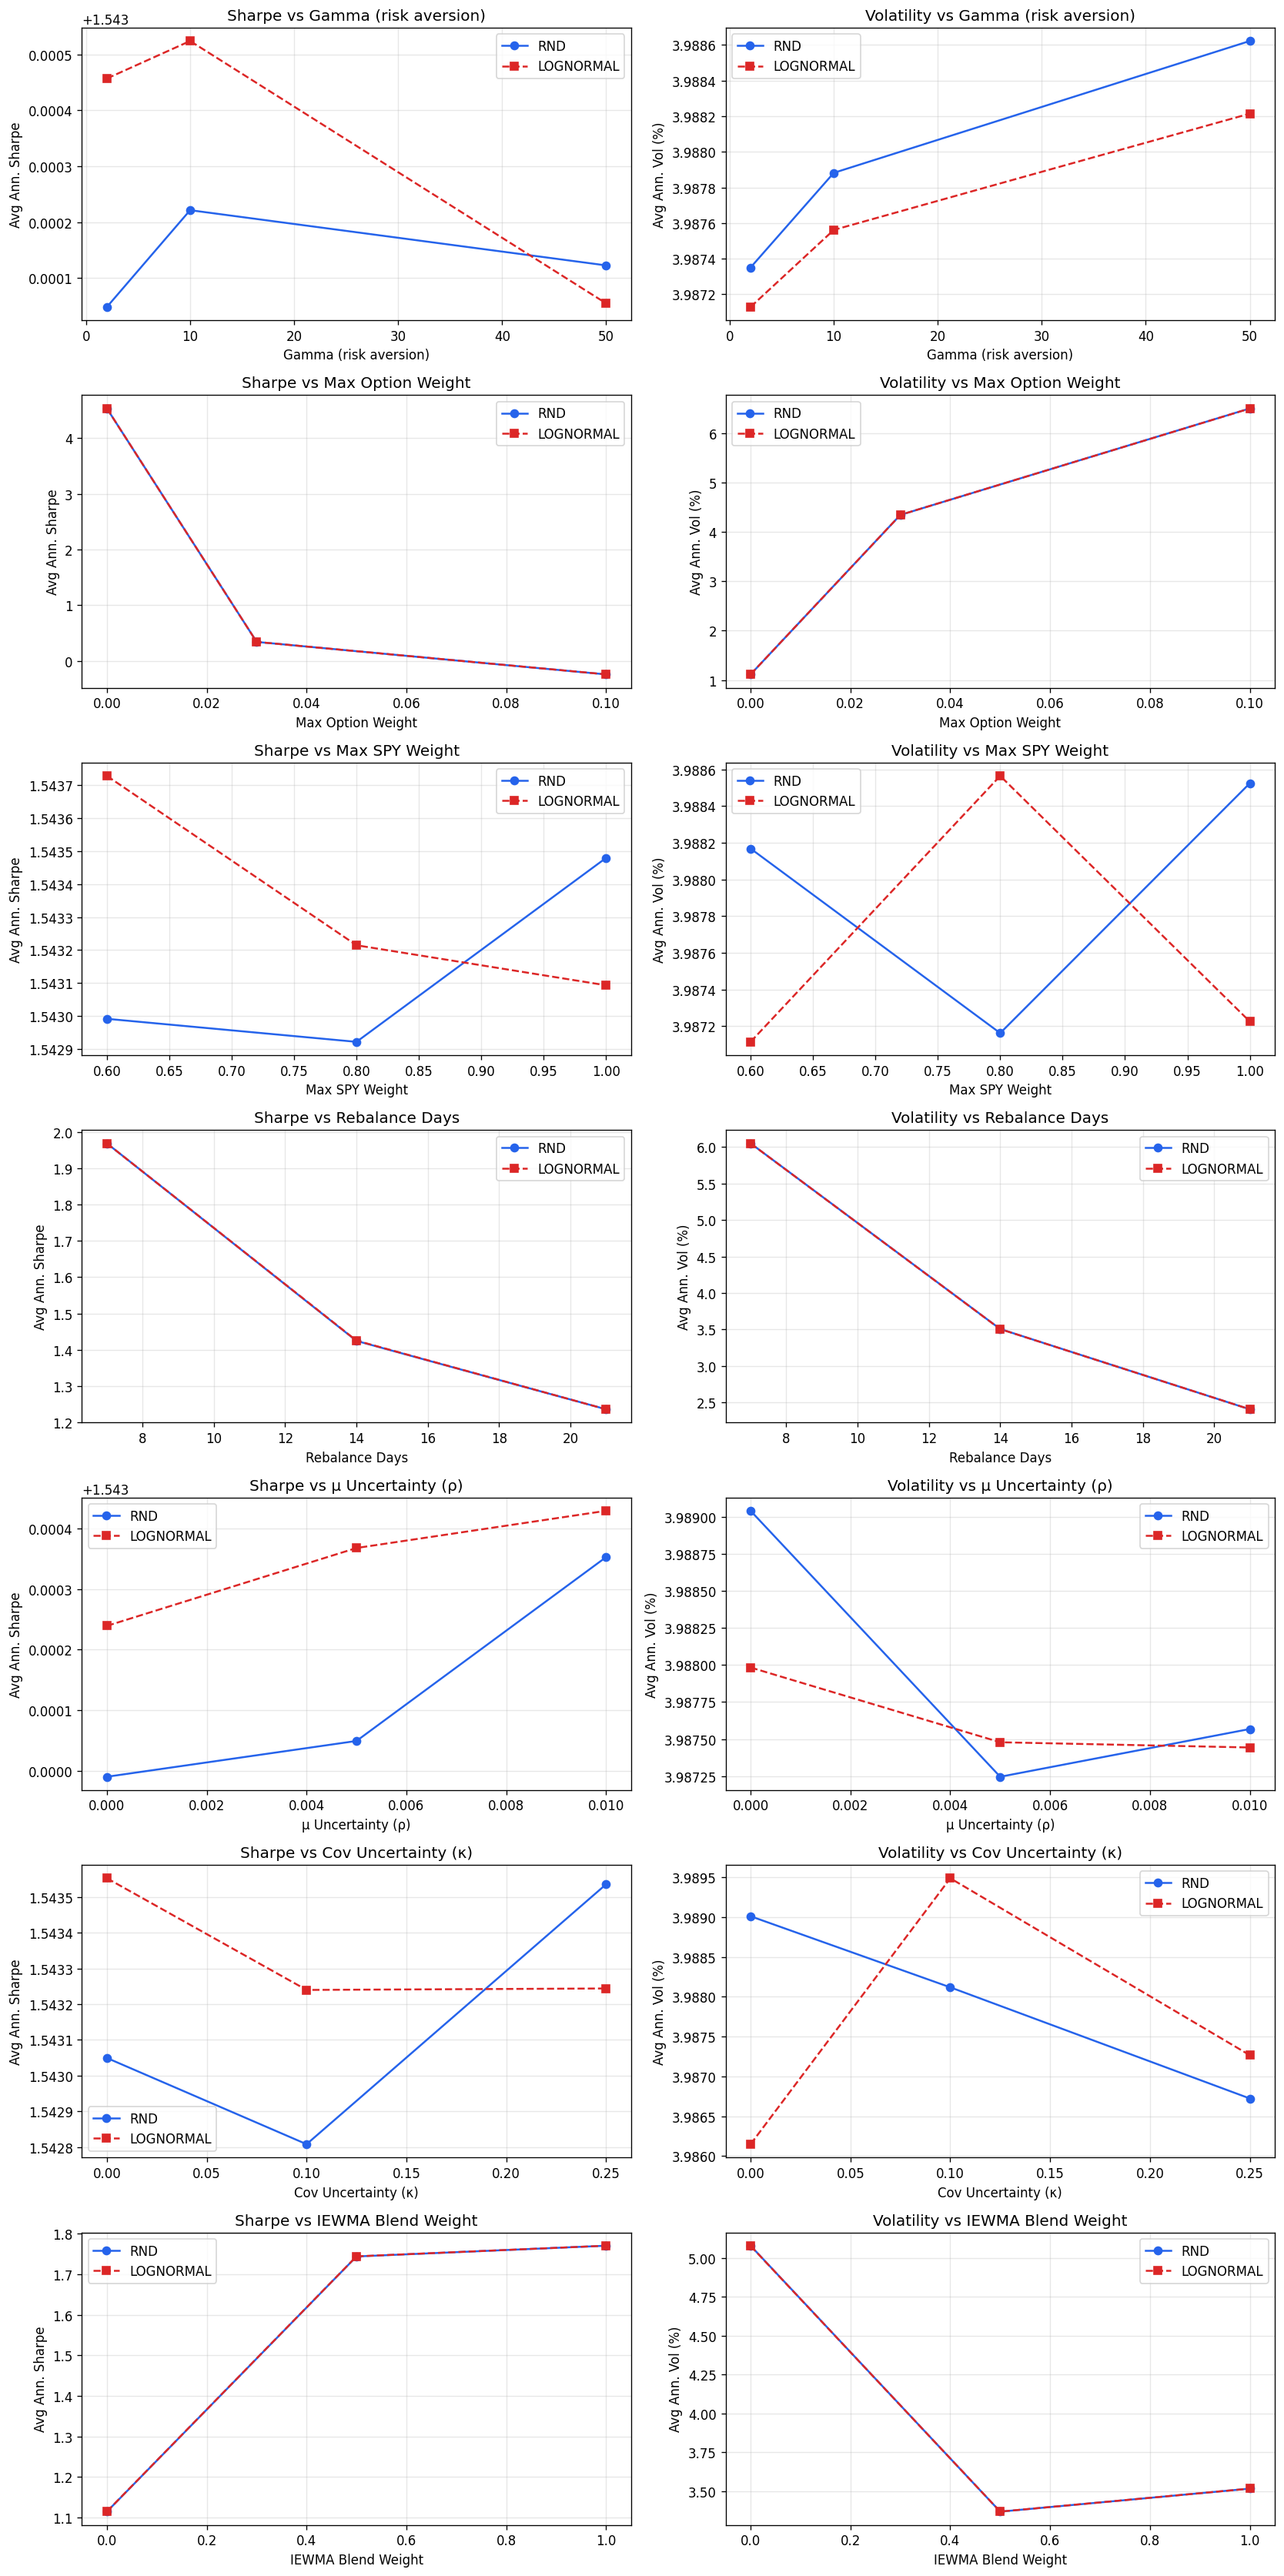

In [14]:
params_info = [
    ("gamma",           "Gamma (risk aversion)",       SWEEP_GAMMAS),
    ("max_opt_wt",      "Max Option Weight",           SWEEP_MAX_OPT_WT),
    ("max_spy_wt",      "Max SPY Weight",              SWEEP_MAX_SPY_WT),
    ("rebal_days",      "Rebalance Days",              SWEEP_REBAL_DAYS),
    ("mu_uncertainty",  "μ Uncertainty (ρ)",           SWEEP_MU_UNCERT),
    ("cov_uncertainty", "Cov Uncertainty (κ)",         SWEEP_COV_UNCERT),
    ("iewma_weight",    "IEWMA Blend Weight",          SWEEP_IEWMA_WT),
]
colors_dist = {"rnd": "#2563eb", "lognormal": "#dc2626"}

fig, axes = plt.subplots(len(params_info), 2, figsize=(14, 4 * len(params_info)))

for row, (col, label, vals) in enumerate(params_info):
    for dist in SWEEP_DISTRIBUTIONS:
        sub = sweep_df[sweep_df["distribution"] == dist]
        grp = sub.groupby(col)[["sharpe", "ann_vol"]].mean().reindex(vals)
        style = "o-" if dist == "rnd" else "s--"
        axes[row, 0].plot(grp.index, grp["sharpe"], style, color=colors_dist[dist], label=dist.upper())
        axes[row, 1].plot(grp.index, grp["ann_vol"] * 100, style, color=colors_dist[dist], label=dist.upper())

    axes[row, 0].set_xlabel(label)
    axes[row, 0].set_ylabel("Avg Ann. Sharpe")
    axes[row, 0].set_title(f"Sharpe vs {label}")
    axes[row, 0].legend()
    axes[row, 1].set_xlabel(label)
    axes[row, 1].set_ylabel("Avg Ann. Vol (%)")
    axes[row, 1].set_title(f"Volatility vs {label}")
    axes[row, 1].legend()

plt.tight_layout()
display(fig)
plt.close(fig)

### 5c  Heatmaps — Gamma × Max Option Weight (by Distribution & Rebalance Period)

Sharpe ratio heatmaps sliced by **rebalance period** and **distribution method**.
Each heatmap shows Gamma on the y-axis and Max Option Weight on the x-axis,
averaged over Max SPY Weight values.

/var/folders/v7/fy28j8pd6yb_vb5vddcfccd00000gn/T/ipykernel_35560/3852804307.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


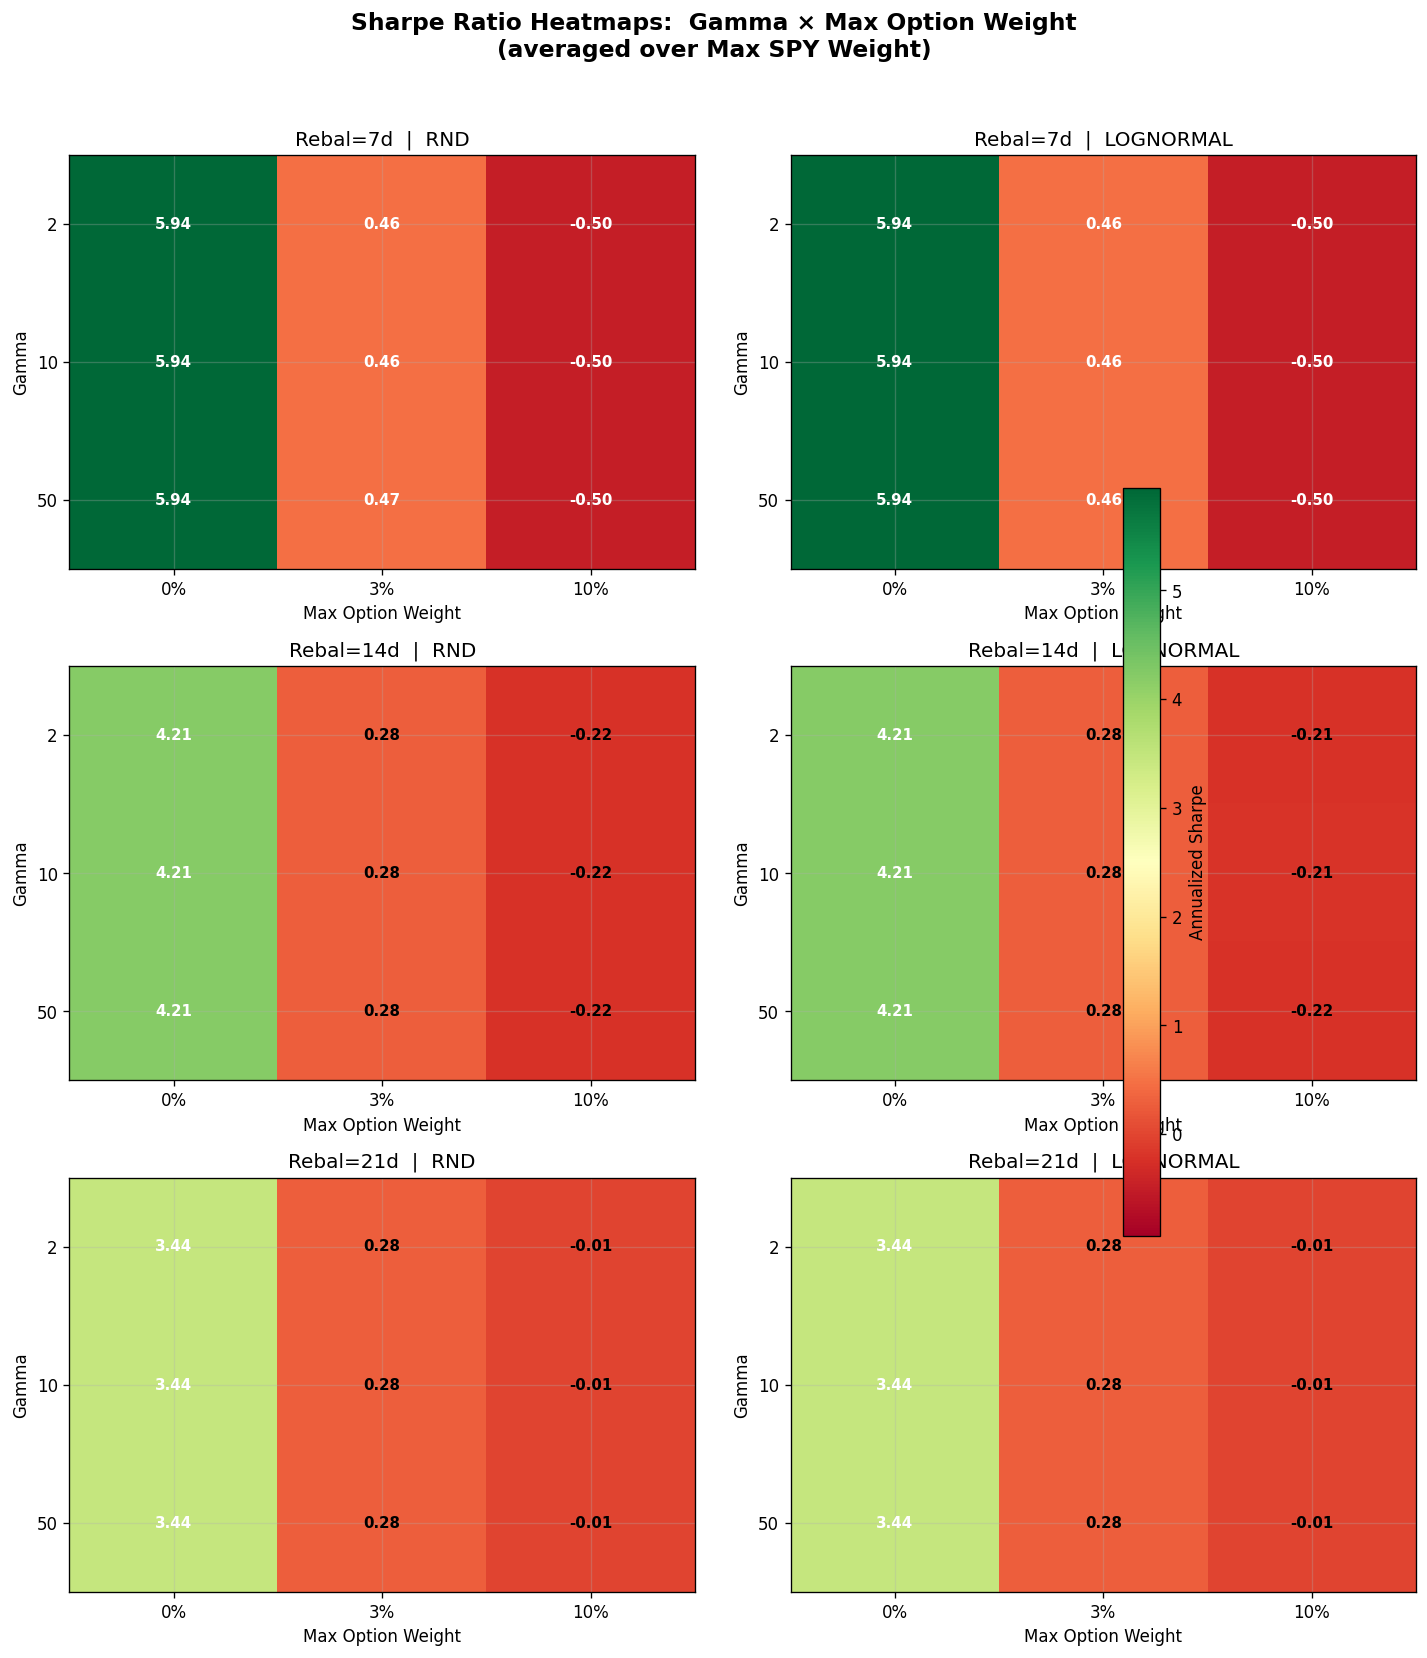

In [15]:
n_rebal = len(SWEEP_REBAL_DAYS)
n_dist  = len(SWEEP_DISTRIBUTIONS)

fig, axes = plt.subplots(n_rebal, n_dist, figsize=(6 * n_dist, 4.5 * n_rebal),
                         squeeze=False)
fig.suptitle("Sharpe Ratio Heatmaps:  Gamma × Max Option Weight\n"
             "(averaged over Max SPY Weight)", fontsize=14, fontweight="bold", y=1.02)

for i, rd in enumerate(SWEEP_REBAL_DAYS):
    for j, dist in enumerate(SWEEP_DISTRIBUTIONS):
        ax = axes[i, j]
        sub = sweep_df[(sweep_df["rebal_days"] == rd) & (sweep_df["distribution"] == dist)]
        pivot = sub.groupby(["gamma", "max_opt_wt"])["sharpe"].mean().unstack()
        pivot = pivot.reindex(index=SWEEP_GAMMAS, columns=SWEEP_MAX_OPT_WT)

        im = ax.imshow(pivot.values, aspect="auto", cmap="RdYlGn",
                       vmin=sweep_df["sharpe"].quantile(0.05),
                       vmax=sweep_df["sharpe"].quantile(0.95))
        ax.set_xticks(range(len(SWEEP_MAX_OPT_WT)))
        ax.set_xticklabels([f"{v:.0%}" for v in SWEEP_MAX_OPT_WT])
        ax.set_yticks(range(len(SWEEP_GAMMAS)))
        ax.set_yticklabels([str(g) for g in SWEEP_GAMMAS])
        ax.set_xlabel("Max Option Weight")
        ax.set_ylabel("Gamma")
        ax.set_title(f"Rebal={rd}d  |  {dist.upper()}")

        for yi in range(len(SWEEP_GAMMAS)):
            for xi in range(len(SWEEP_MAX_OPT_WT)):
                val = pivot.values[yi, xi]
                ax.text(xi, yi, f"{val:.2f}", ha="center", va="center",
                        fontsize=9, fontweight="bold",
                        color="white" if abs(val) > 0.3 else "black")

fig.colorbar(im, ax=axes, shrink=0.6, label="Annualized Sharpe")
plt.tight_layout()
display(fig)
plt.close(fig)

### 5d  Heatmaps — Max SPY Weight × Rebalance Days (by Distribution)

Sharpe ratio heatmaps with Max SPY Weight on the y-axis and Rebalance Days on the
x-axis, averaged over Gamma and Max Option Weight.

/var/folders/v7/fy28j8pd6yb_vb5vddcfccd00000gn/T/ipykernel_35560/1706587179.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


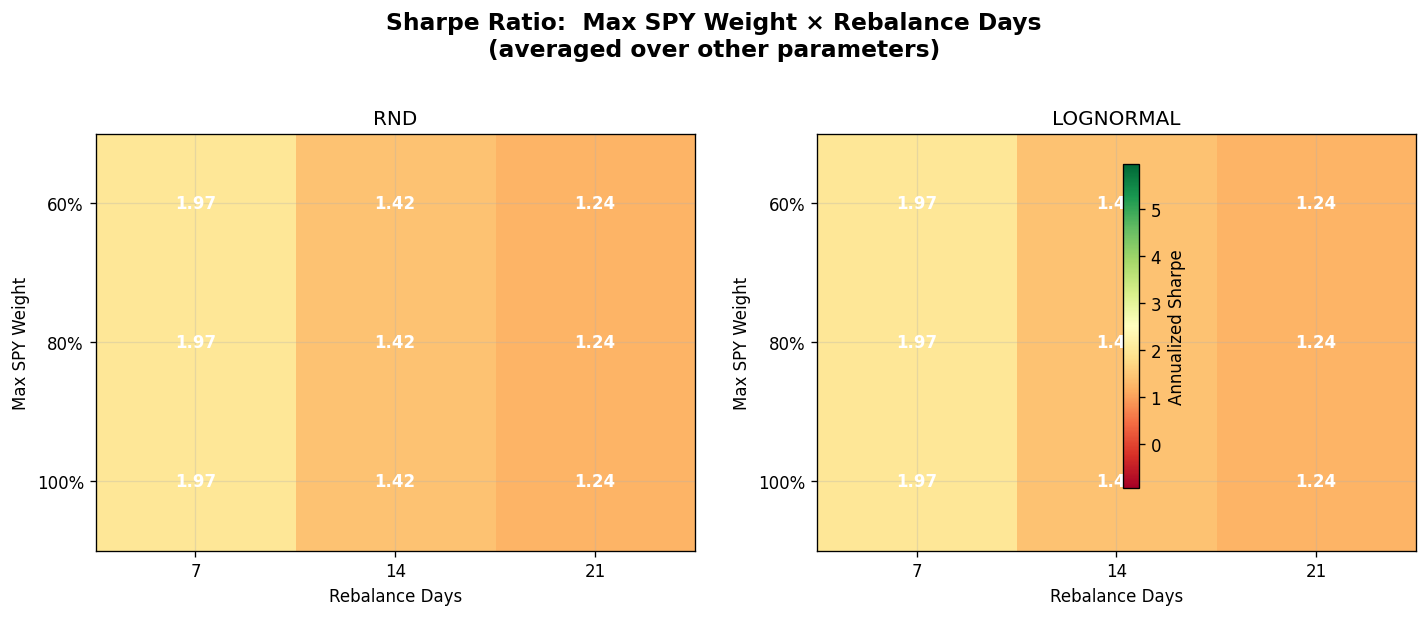

In [16]:
fig, axes = plt.subplots(1, n_dist, figsize=(6 * n_dist, 5), squeeze=False)
fig.suptitle("Sharpe Ratio:  Max SPY Weight × Rebalance Days\n"
             "(averaged over other parameters)",
             fontsize=14, fontweight="bold", y=1.02)

for j, dist in enumerate(SWEEP_DISTRIBUTIONS):
    ax = axes[0, j]
    sub = sweep_df[sweep_df["distribution"] == dist]
    pivot = sub.groupby(["max_spy_wt", "rebal_days"])["sharpe"].mean().unstack()
    pivot = pivot.reindex(index=SWEEP_MAX_SPY_WT, columns=SWEEP_REBAL_DAYS)

    im = ax.imshow(pivot.values, aspect="auto", cmap="RdYlGn",
                   vmin=sweep_df["sharpe"].quantile(0.05),
                   vmax=sweep_df["sharpe"].quantile(0.95))
    ax.set_xticks(range(len(SWEEP_REBAL_DAYS)))
    ax.set_xticklabels([str(r) for r in SWEEP_REBAL_DAYS])
    ax.set_yticks(range(len(SWEEP_MAX_SPY_WT)))
    ax.set_yticklabels([f"{v:.0%}" for v in SWEEP_MAX_SPY_WT])
    ax.set_xlabel("Rebalance Days")
    ax.set_ylabel("Max SPY Weight")
    ax.set_title(f"{dist.upper()}")

    for yi in range(len(SWEEP_MAX_SPY_WT)):
        for xi in range(len(SWEEP_REBAL_DAYS)):
            val = pivot.values[yi, xi]
            ax.text(xi, yi, f"{val:.2f}", ha="center", va="center",
                    fontsize=10, fontweight="bold",
                    color="white" if abs(val) > 0.3 else "black")

fig.colorbar(im, ax=axes, shrink=0.7, label="Annualized Sharpe")
plt.tight_layout()
display(fig)
plt.close(fig)

### 5e  Heatmaps — Robust Optimization Parameters

Sharpe ratio heatmaps for the new **robust optimization** dimensions:
- **μ Uncertainty (ρ) × Cov Uncertainty (κ)** — averaged over all other params
- **IEWMA Weight × Cov Uncertainty (κ)** — averaged over all other params

/var/folders/v7/fy28j8pd6yb_vb5vddcfccd00000gn/T/ipykernel_35560/1036679567.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


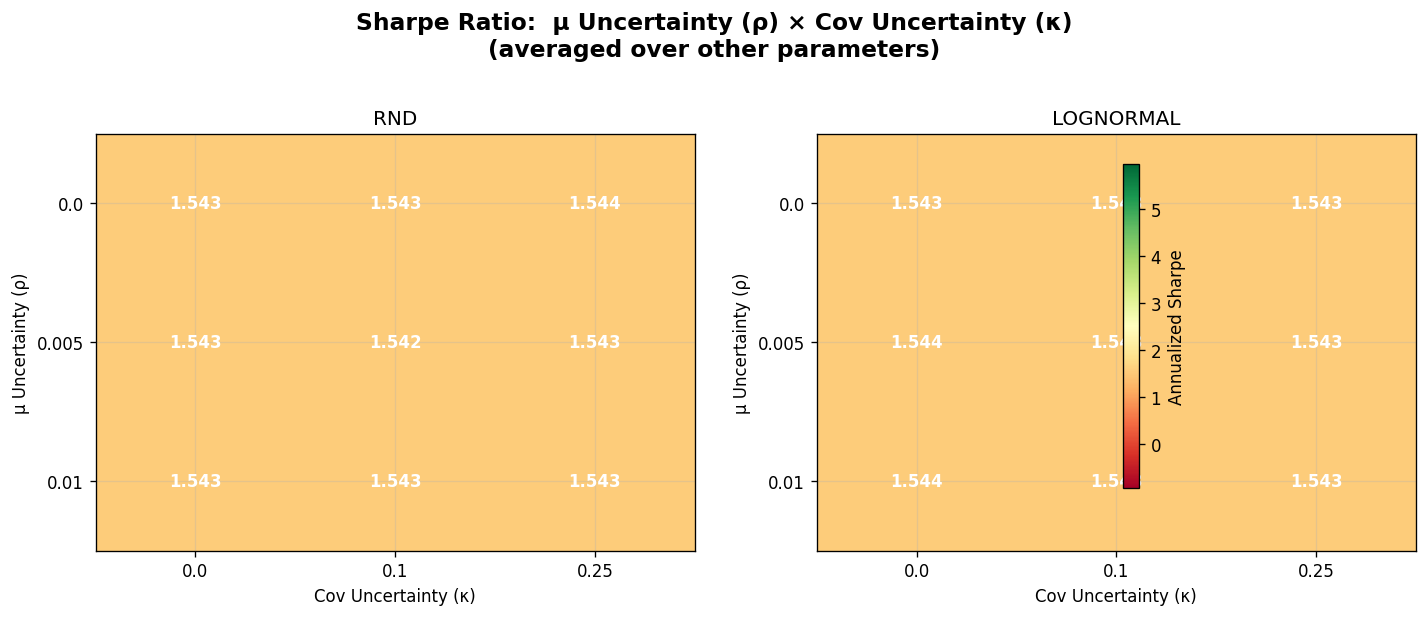

/var/folders/v7/fy28j8pd6yb_vb5vddcfccd00000gn/T/ipykernel_35560/1036679567.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


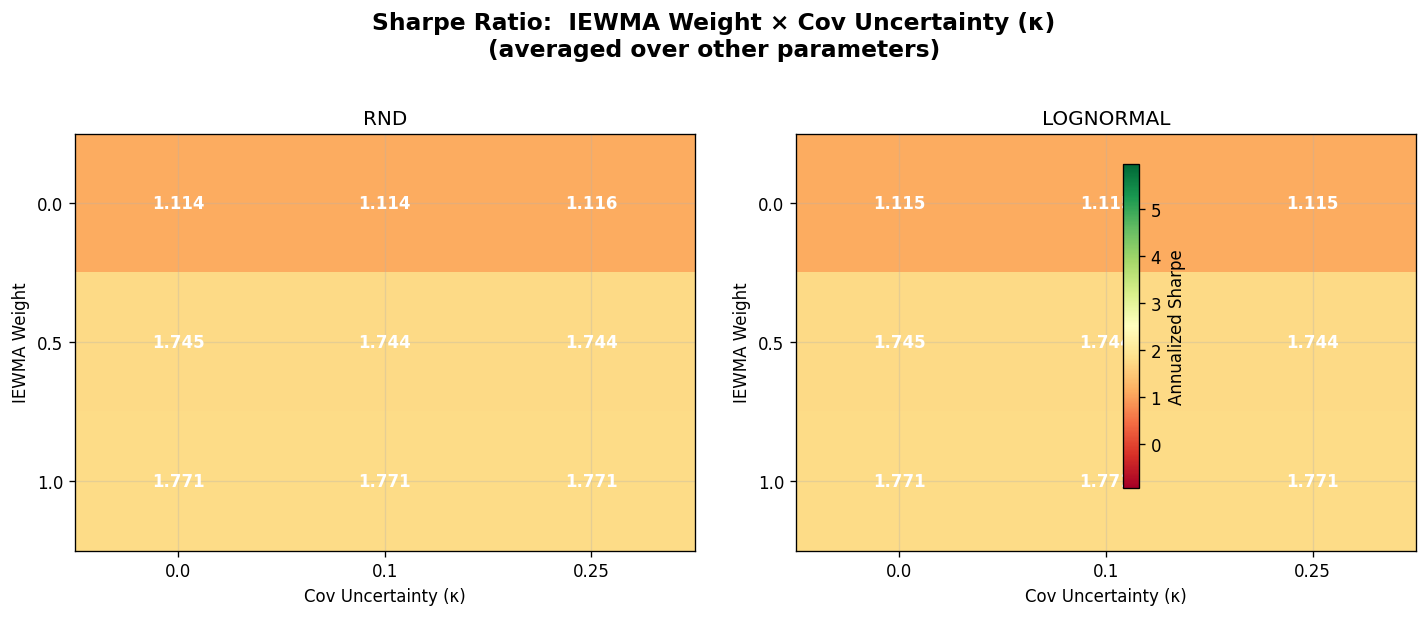

/var/folders/v7/fy28j8pd6yb_vb5vddcfccd00000gn/T/ipykernel_35560/1036679567.py:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


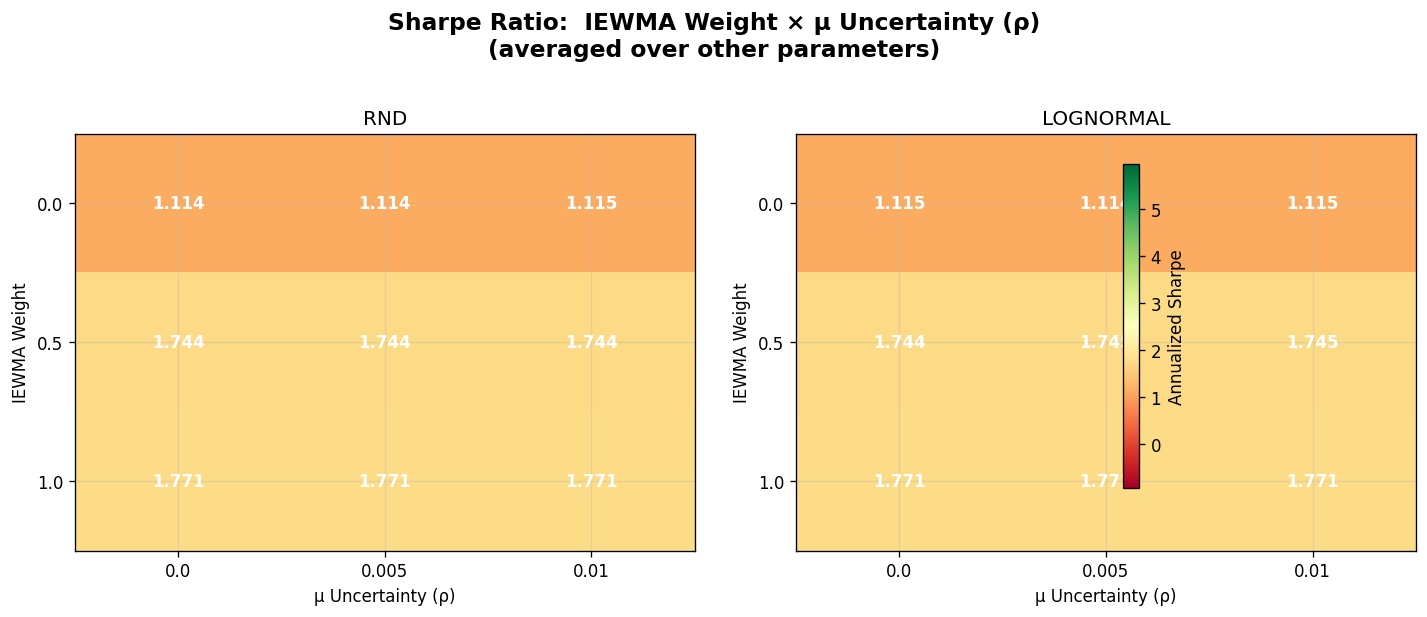

In [17]:
# --- Heatmap 1: mu_uncertainty × cov_uncertainty (by distribution) ---
fig, axes = plt.subplots(1, n_dist, figsize=(6 * n_dist, 5), squeeze=False)
fig.suptitle("Sharpe Ratio:  μ Uncertainty (ρ) × Cov Uncertainty (κ)\n"
             "(averaged over other parameters)",
             fontsize=14, fontweight="bold", y=1.02)

for j, dist in enumerate(SWEEP_DISTRIBUTIONS):
    ax = axes[0, j]
    sub = sweep_df[sweep_df["distribution"] == dist]
    pivot = sub.groupby(["mu_uncertainty", "cov_uncertainty"])["sharpe"].mean().unstack()
    pivot = pivot.reindex(index=SWEEP_MU_UNCERT, columns=SWEEP_COV_UNCERT)

    im = ax.imshow(pivot.values, aspect="auto", cmap="RdYlGn",
                   vmin=sweep_df["sharpe"].quantile(0.05),
                   vmax=sweep_df["sharpe"].quantile(0.95))
    ax.set_xticks(range(len(SWEEP_COV_UNCERT)))
    ax.set_xticklabels([str(v) for v in SWEEP_COV_UNCERT])
    ax.set_yticks(range(len(SWEEP_MU_UNCERT)))
    ax.set_yticklabels([str(v) for v in SWEEP_MU_UNCERT])
    ax.set_xlabel("Cov Uncertainty (κ)")
    ax.set_ylabel("μ Uncertainty (ρ)")
    ax.set_title(f"{dist.upper()}")

    for yi in range(len(SWEEP_MU_UNCERT)):
        for xi in range(len(SWEEP_COV_UNCERT)):
            val = pivot.values[yi, xi]
            ax.text(xi, yi, f"{val:.3f}", ha="center", va="center",
                    fontsize=10, fontweight="bold",
                    color="white" if abs(val) > 0.3 else "black")

fig.colorbar(im, ax=axes, shrink=0.7, label="Annualized Sharpe")
plt.tight_layout()
display(fig)
plt.close(fig)

# --- Heatmap 2: iewma_weight × cov_uncertainty (by distribution) ---
fig, axes = plt.subplots(1, n_dist, figsize=(6 * n_dist, 5), squeeze=False)
fig.suptitle("Sharpe Ratio:  IEWMA Weight × Cov Uncertainty (κ)\n"
             "(averaged over other parameters)",
             fontsize=14, fontweight="bold", y=1.02)

for j, dist in enumerate(SWEEP_DISTRIBUTIONS):
    ax = axes[0, j]
    sub = sweep_df[sweep_df["distribution"] == dist]
    pivot = sub.groupby(["iewma_weight", "cov_uncertainty"])["sharpe"].mean().unstack()
    pivot = pivot.reindex(index=SWEEP_IEWMA_WT, columns=SWEEP_COV_UNCERT)

    im = ax.imshow(pivot.values, aspect="auto", cmap="RdYlGn",
                   vmin=sweep_df["sharpe"].quantile(0.05),
                   vmax=sweep_df["sharpe"].quantile(0.95))
    ax.set_xticks(range(len(SWEEP_COV_UNCERT)))
    ax.set_xticklabels([str(v) for v in SWEEP_COV_UNCERT])
    ax.set_yticks(range(len(SWEEP_IEWMA_WT)))
    ax.set_yticklabels([str(v) for v in SWEEP_IEWMA_WT])
    ax.set_xlabel("Cov Uncertainty (κ)")
    ax.set_ylabel("IEWMA Weight")
    ax.set_title(f"{dist.upper()}")

    for yi in range(len(SWEEP_IEWMA_WT)):
        for xi in range(len(SWEEP_COV_UNCERT)):
            val = pivot.values[yi, xi]
            ax.text(xi, yi, f"{val:.3f}", ha="center", va="center",
                    fontsize=10, fontweight="bold",
                    color="white" if abs(val) > 0.3 else "black")

fig.colorbar(im, ax=axes, shrink=0.7, label="Annualized Sharpe")
plt.tight_layout()
display(fig)
plt.close(fig)

# --- Heatmap 3: iewma_weight × mu_uncertainty (by distribution) ---
fig, axes = plt.subplots(1, n_dist, figsize=(6 * n_dist, 5), squeeze=False)
fig.suptitle("Sharpe Ratio:  IEWMA Weight × μ Uncertainty (ρ)\n"
             "(averaged over other parameters)",
             fontsize=14, fontweight="bold", y=1.02)

for j, dist in enumerate(SWEEP_DISTRIBUTIONS):
    ax = axes[0, j]
    sub = sweep_df[sweep_df["distribution"] == dist]
    pivot = sub.groupby(["iewma_weight", "mu_uncertainty"])["sharpe"].mean().unstack()
    pivot = pivot.reindex(index=SWEEP_IEWMA_WT, columns=SWEEP_MU_UNCERT)

    im = ax.imshow(pivot.values, aspect="auto", cmap="RdYlGn",
                   vmin=sweep_df["sharpe"].quantile(0.05),
                   vmax=sweep_df["sharpe"].quantile(0.95))
    ax.set_xticks(range(len(SWEEP_MU_UNCERT)))
    ax.set_xticklabels([str(v) for v in SWEEP_MU_UNCERT])
    ax.set_yticks(range(len(SWEEP_IEWMA_WT)))
    ax.set_yticklabels([str(v) for v in SWEEP_IEWMA_WT])
    ax.set_xlabel("μ Uncertainty (ρ)")
    ax.set_ylabel("IEWMA Weight")
    ax.set_title(f"{dist.upper()}")

    for yi in range(len(SWEEP_IEWMA_WT)):
        for xi in range(len(SWEEP_MU_UNCERT)):
            val = pivot.values[yi, xi]
            ax.text(xi, yi, f"{val:.3f}", ha="center", va="center",
                    fontsize=10, fontweight="bold",
                    color="white" if abs(val) > 0.3 else "black")

fig.colorbar(im, ax=axes, shrink=0.7, label="Annualized Sharpe")
plt.tight_layout()
display(fig)
plt.close(fig)

### 5f  Best & Worst Parameter Combinations

Top-10 and bottom-10 parameter combos ranked by Sharpe ratio.

In [18]:
ranked = sweep_df.sort_values("sharpe", ascending=False).reset_index(drop=True)

fmt = {
    "return":          "{:+.2%}".format,
    "sharpe":          "{:.3f}".format,
    "ann_vol":         "{:.2%}".format,
    "max_opt_wt":      "{:.0%}".format,
    "max_spy_wt":      "{:.0%}".format,
    "mu_uncertainty":  "{:.4f}".format,
    "cov_uncertainty": "{:.2f}".format,
    "iewma_weight":    "{:.2f}".format,
}

display_cols = [
    "gamma", "max_opt_wt", "max_spy_wt", "rebal_days", "distribution",
    "mu_uncertainty", "cov_uncertainty", "iewma_weight",
    "return", "sharpe", "ann_vol",
]

print("=" * 110)
print("  TOP 10 PARAMETER COMBINATIONS (by Sharpe)")
print("=" * 110)
top10 = ranked.head(10).copy()
for c, f in fmt.items():
    if c in top10.columns:
        top10[c] = top10[c].apply(f)
display(top10[display_cols])

print("\n" + "=" * 110)
print("  BOTTOM 10 PARAMETER COMBINATIONS (by Sharpe)")
print("=" * 110)
bot10 = ranked.tail(10).copy()
for c, f in fmt.items():
    if c in bot10.columns:
        bot10[c] = bot10[c].apply(f)
display(bot10[display_cols])

  TOP 10 PARAMETER COMBINATIONS (by Sharpe)


,gamma,max_opt_wt,max_spy_wt,rebal_days,distribution,mu_uncertainty,cov_uncertainty,iewma_weight,return,sharpe,ann_vol
0,2,0%,60%,7,lognormal,0.0050,0.00,1.00,+12.53%,5.945,1.46%
1,50,0%,60%,7,lognormal,0.0050,0.00,1.00,+12.53%,5.945,1.46%
2,2,0%,60%,7,lognormal,0.0000,0.00,1.00,+12.53%,5.945,1.46%
3,50,0%,60%,7,lognormal,0.0000,0.25,1.00,+12.53%,5.945,1.46%
4,10,0%,60%,7,lognormal,0.0000,0.00,1.00,+12.53%,5.945,1.46%
5,2,0%,60%,7,rnd,0.0000,0.25,1.00,+12.53%,5.945,1.46%
6,50,0%,60%,7,rnd,0.0100,0.00,1.00,+12.53%,5.945,1.46%
7,50,0%,60%,7,rnd,0.0000,0.00,1.00,+12.53%,5.945,1.46%
8,50,0%,60%,7,rnd,0.0050,0.25,1.00,+12.53%,5.945,1.46%
9,2,0%,60%,7,rnd,0.0050,0.10,1.00,+12.53%,5.945,1.46%



  BOTTOM 10 PARAMETER COMBINATIONS (by Sharpe)


,gamma,max_opt_wt,max_spy_wt,rebal_days,distribution,mu_uncertainty,cov_uncertainty,iewma_weight,return,sharpe,ann_vol
4364,50,10%,80%,7,lognormal,0.0100,0.10,0.00,-31.37%,-1.640,16.00%
4365,50,10%,80%,7,lognormal,0.0100,0.00,0.00,-31.54%,-1.641,16.09%
4366,50,10%,100%,7,rnd,0.0000,0.00,0.00,-31.34%,-1.643,15.95%
4367,50,10%,80%,7,lognormal,0.0000,0.00,0.00,-31.48%,-1.647,16.00%
4368,50,10%,80%,7,lognormal,0.0050,0.25,0.00,-31.46%,-1.649,15.97%
4369,10,10%,100%,7,rnd,0.0000,0.10,0.00,-31.54%,-1.651,16.00%
4370,10,10%,80%,7,rnd,0.0050,0.10,0.00,-31.41%,-1.654,15.89%
4371,2,10%,80%,7,rnd,0.0100,0.00,0.00,-31.74%,-1.655,16.09%
4372,50,10%,60%,7,rnd,0.0100,0.25,0.00,-31.55%,-1.660,15.93%
4373,2,10%,80%,7,lognormal,0.0000,0.00,0.00,-31.75%,-1.664,16.02%
